In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 기본 탐색

In [2]:
df = pd.read_csv('houseprice.csv')

In [3]:
df.head(), df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

# 전처리

In [4]:
## 결측치 확인
isnull_series = df.isnull().sum()
isnull_series[isnull_series>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

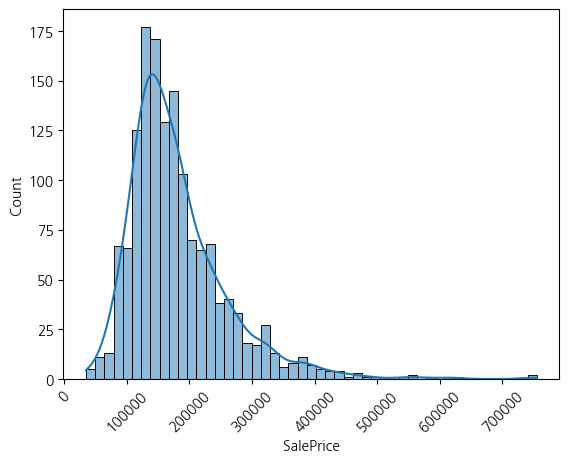

In [5]:
## 분산 확인
plt.xticks(rotation=45)
sns.histplot(df['SalePrice'], kde=True)
plt.show()

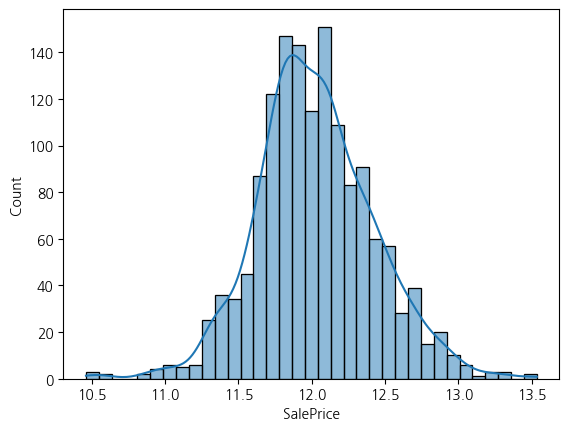

In [6]:
## 스케일링, 정규화
### -> 타겟값이 정규분포가 아니라면, 정규분포화 해준 후 분석하는 것이 효과적이다.
log_saleprice = np.log1p(df['SalePrice'])
sns.histplot(log_saleprice, kde=True)
plt.show()

### 로그취한 값을 덮어쓰기
original_saleprice = df['SalePrice']
df['SalePrice'] = np.log1p(df['SalePrice'])

### 필요없는 칼럼 제거, na값 많은 칼럼 제거
df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Id'], inplace=True)



In [7]:
## 그 외 na값 처리
### 수치값 칼럼은 평균값으로 대체
df.fillna(df.mean(), inplace=True)

### Object타입인 칼럼들만이 남았다.
### 확인해보자
null_column_count = df.isnull().sum()[df.isnull().sum()>0]
df.dtypes[null_column_count.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

## 원 핫 인코딩 (오브젝트 -> 범주화)

In [8]:
## Object 타입은 인코딩으로 범주화 처리를 한다.
df_ohe = pd.get_dummies(df)
df_ohe.shape

(1460, 271)

# 평가모델 생성

In [9]:
# RMSE 평가 모델 생성
def get_rmse(model):
    from sklearn.metrics import mean_squared_error
    import numpy as np
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE : ', np.round(rmse,3))
    return rmse

# 여러 모델을 RMSE 평가하는 함수
def get_rmses(models):
    rmses = []
    for model in models:
        rmses.append(get_rmse(model))
    return rmses

# 회귀 개선

In [10]:
## L1, L2 규제를 이용한다.
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [11]:
## 데이터셋 나누기
y = df_ohe['SalePrice']
X = df_ohe.drop(columns = 'SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=156)

In [12]:
## 회귀 모델 지정
## 및 학습 진행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

## 릿지 모델 지정
## 및 학습 진행
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

## 라쏘 모델 지정
## 및 학습 진행
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [13]:
## RMSE값 받아보기
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.128
Lasso 로그 변환된 RMSE :  0.176


[0.13189576579154494, 0.12750846334052998, 0.17628250556471403]

In [15]:
## 로그 변환 - 못봄
np.expm1(0.13189576579154494)

0.14098938294353924

In [16]:
## co_efficient (coef)
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_,index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [17]:
## coef 적용
get_top_bottom_coef(ridge_reg)

(RoofMatl_WdShngl        0.230707
 Neighborhood_StoneBr    0.155361
 RoofMatl_CompShg        0.150847
 Condition2_Norm         0.127309
 Neighborhood_NridgHt    0.123381
 Neighborhood_Crawfor    0.121902
 RoofMatl_WdShake        0.111764
 Heating_GasW            0.099974
 Functional_Typ          0.093985
 MSZoning_FV             0.093818
 dtype: float64,
 GarageQual_Fa          -0.068476
 Neighborhood_Edwards   -0.078395
 GarageType_2Types      -0.080423
 Utilities_NoSeWa       -0.085030
 Heating_Grav           -0.185664
 Neighborhood_MeadowV   -0.192329
 Functional_Maj2        -0.249292
 MSZoning_C (all)       -0.279789
 Condition2_PosN        -0.347434
 RoofMatl_ClyTile       -0.703980
 dtype: float64)

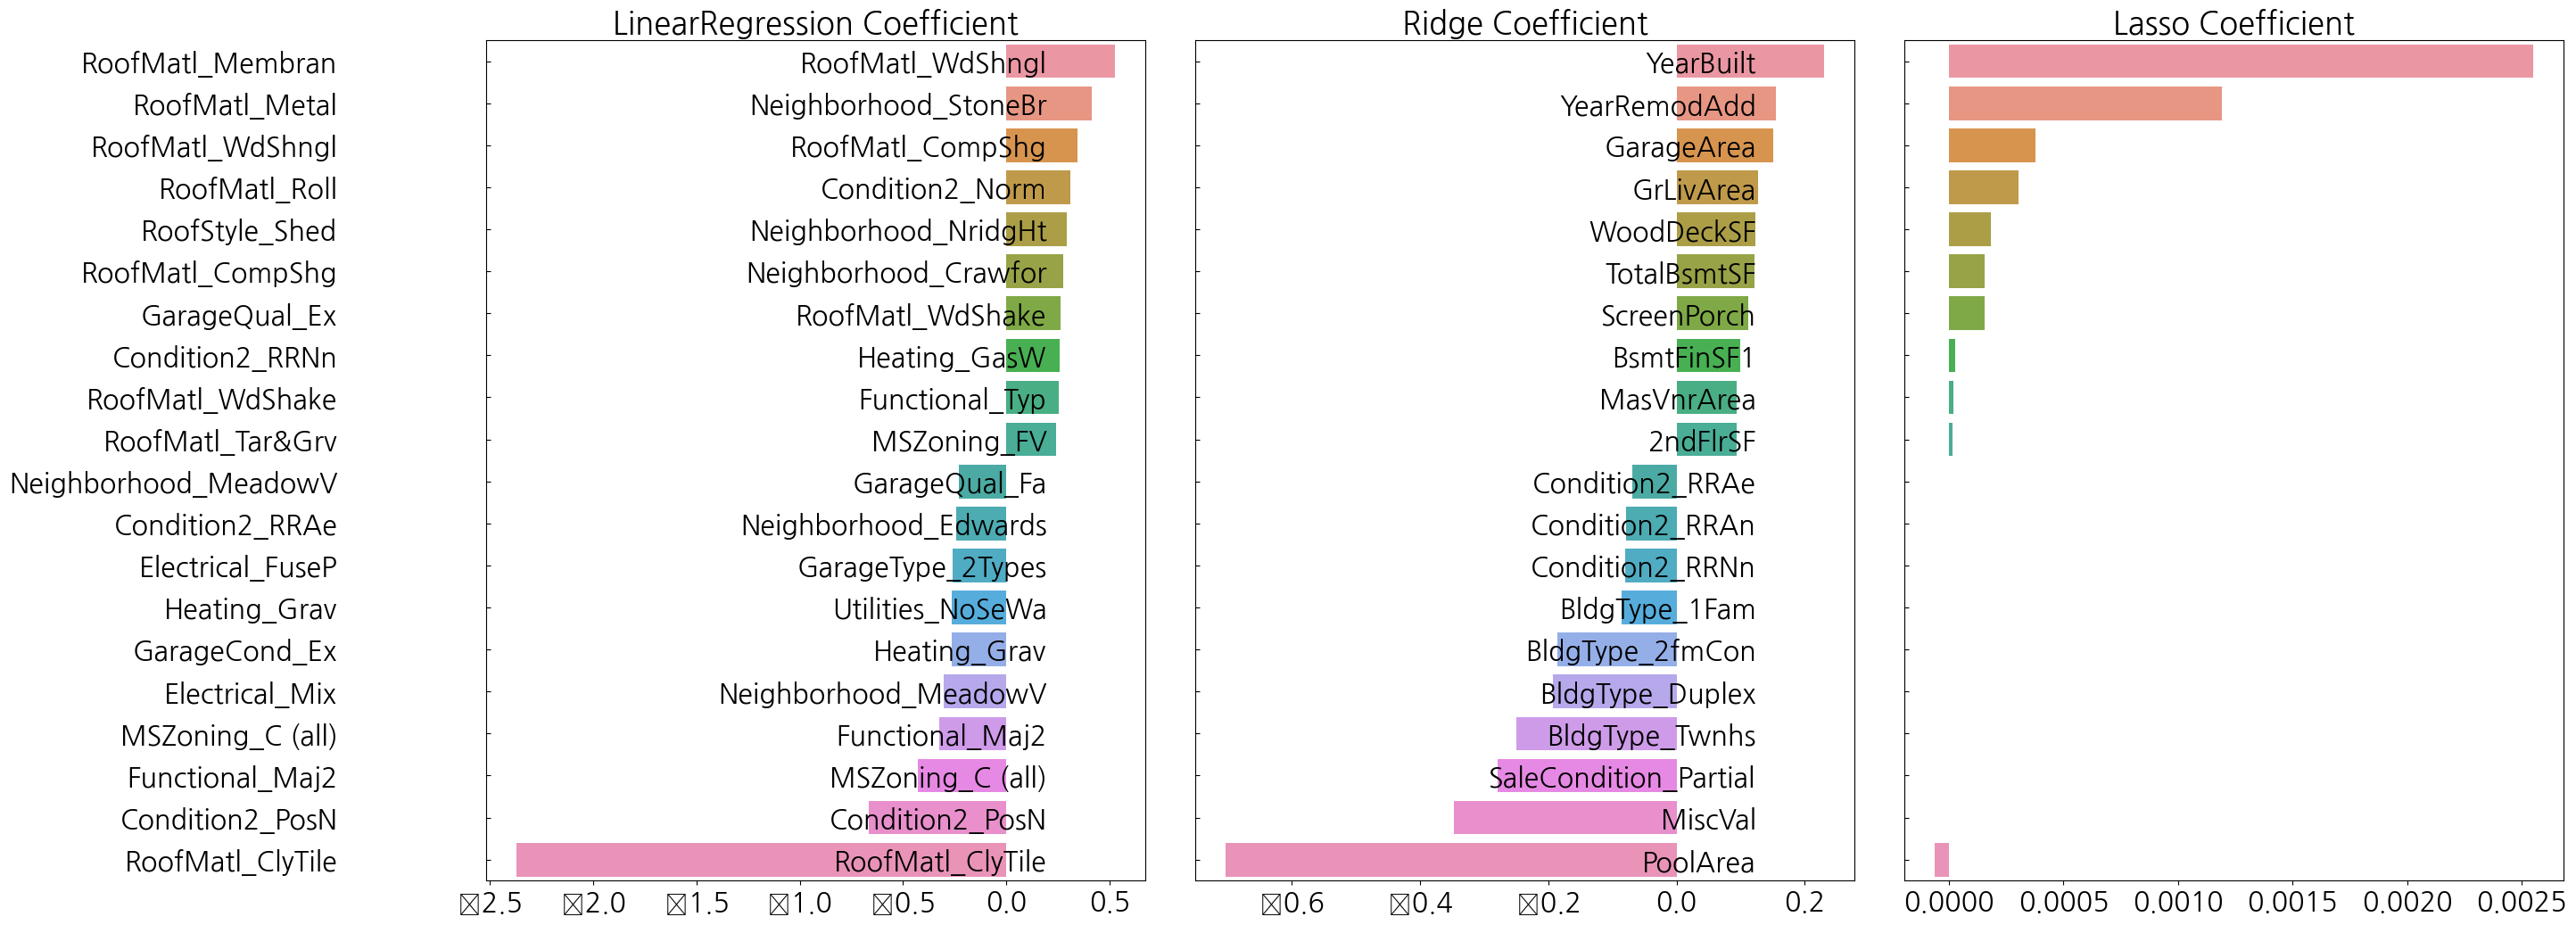

In [18]:
## 주요 요인 확인
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()      # 동일 면에 표시되는 각기 다른 그래프의 표시범주가 비슷해보이게 함
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__+ ' Coefficient', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
visualize_coefficient(models)

## 데이터셋 분할 잘 된 것인지 확인

In [20]:
## 분할 잘 되었는지 확인
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__} cv rmse 값 리스트 : {np.round(rmse_list,3)}')
        print(f'{model.__class__.__name__} cv 평균 rmse 값 리스트 : {np.round(rmse_avg,3)}')
        
get_avg_rmse_cv(models)

LinearRegression cv rmse 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression cv 평균 rmse 값 리스트 : 0.155
Ridge cv rmse 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge cv 평균 rmse 값 리스트 : 0.144
Lasso cv rmse 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso cv 평균 rmse 값 리스트 : 0.198


## 하이퍼파라미터 튜닝 교차검증

In [25]:
## 최적 파라미터 확인 함수
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} 5cv시 최적 평균 rmse 값 : {np.round(rmse,4)}', 
         f' 최적 alpha값 : {grid_model.best_params_}')

In [26]:
## Ridge 모델 파라미터 best param 알아보기
print_best_param = {
    'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]
}

print_best_params(ridge_reg, print_best_param)

## Ridge 모델 파라미터 best param 알아보기
print_best_param = {
    'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]
}

print_best_params(lasso_reg, print_best_param)


Ridge 5cv시 최적 평균 rmse 값 : 0.1418  최적 alpha값 : {'alpha': 12}
Lasso 5cv시 최적 평균 rmse 값 : 0.142  최적 alpha값 : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.124
Lasso 로그 변환된 RMSE :  0.12


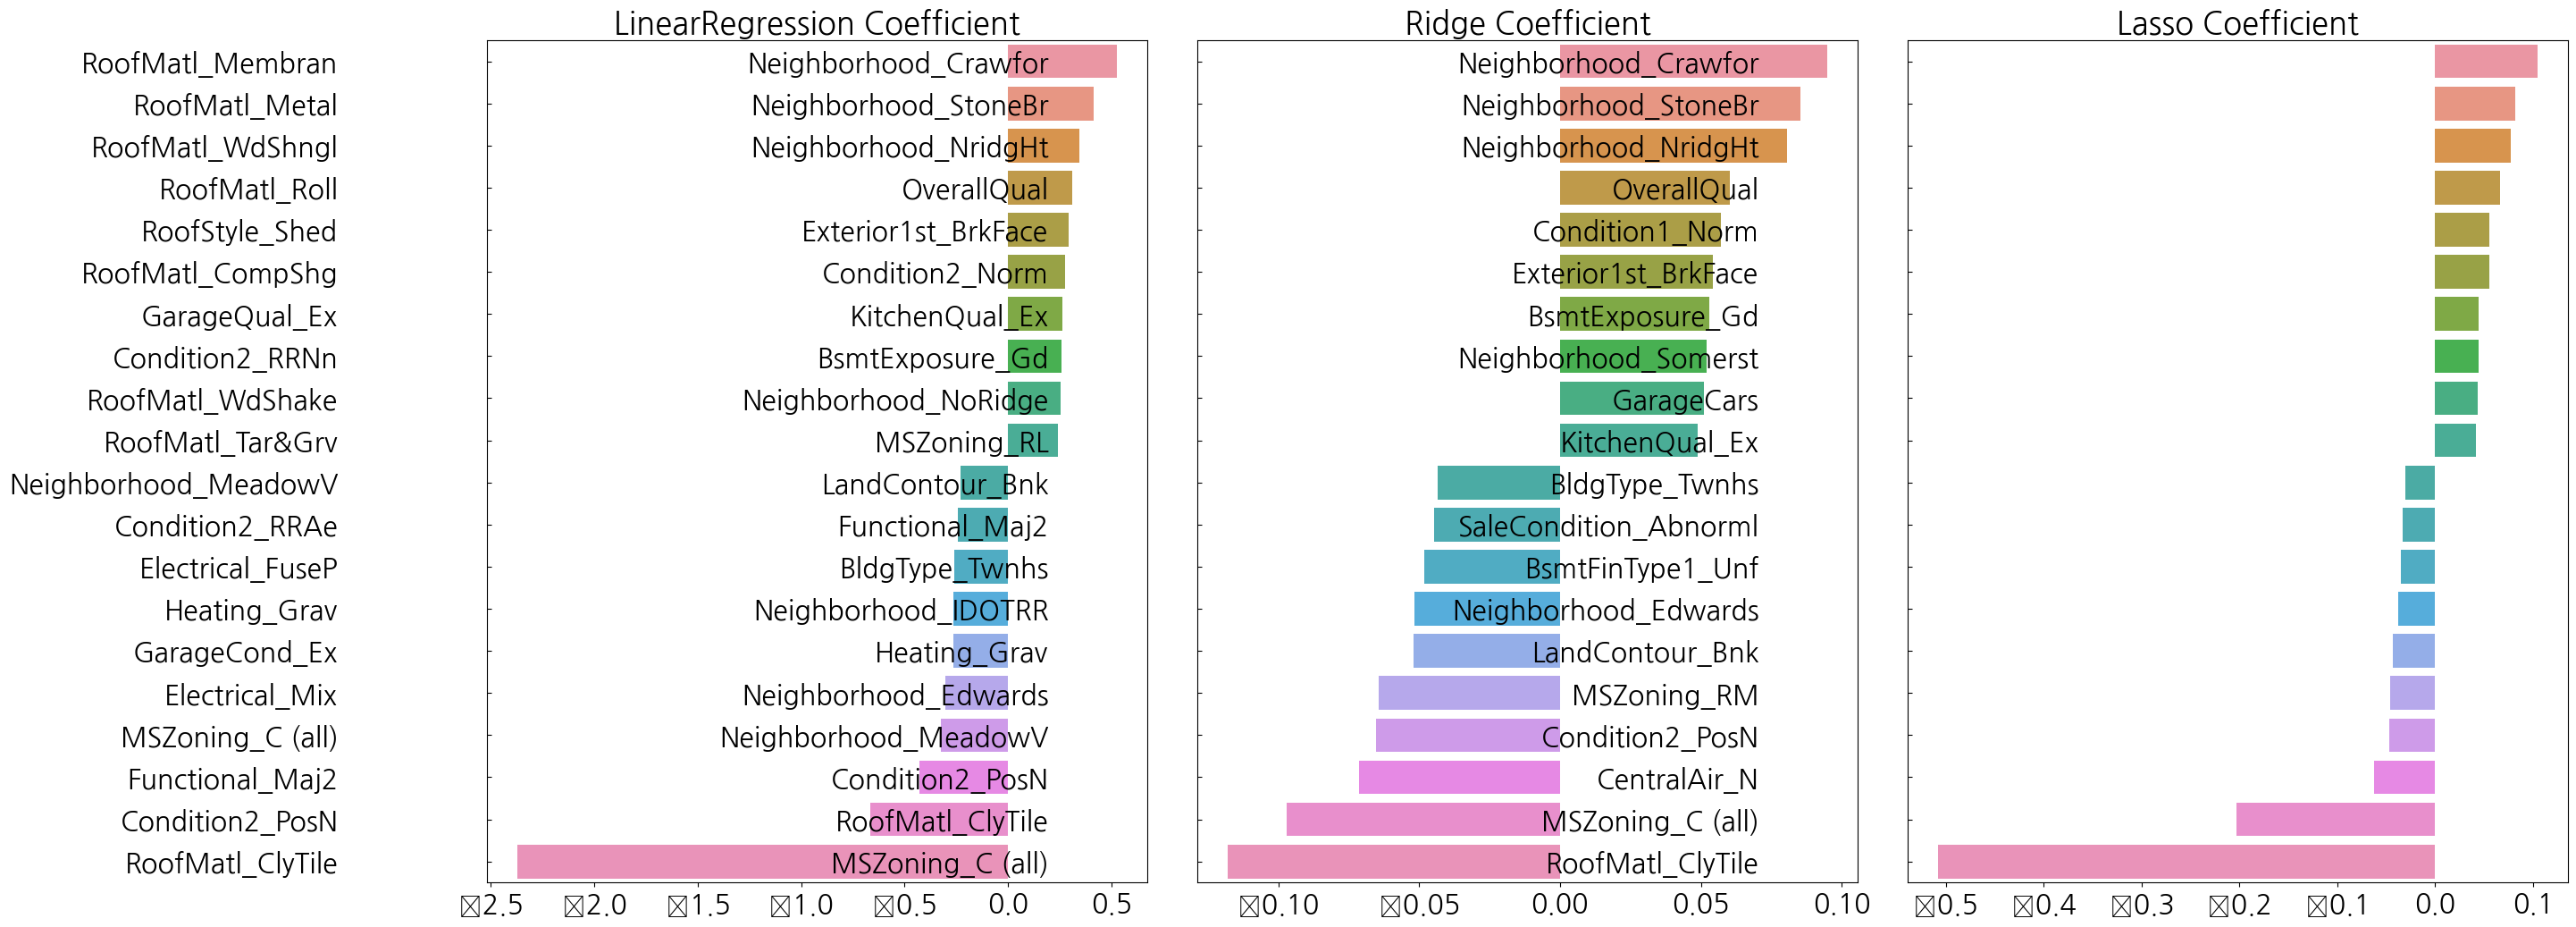

In [27]:
## 회귀 모델 재지정
## 및 학습 진행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

## 릿지 모델 재지정 (알파값 부여)
## 및 학습 진행
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

## 라쏘 모델 재지정
## 및 학습 진행
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

## RMSE값 받아보기
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

## 시각화 확인
visualize_coefficient(models)

# 평가  
  
* 회귀는 분포의 영향을 많이 받는다 -> log 정규화 등이 필요    
* 나머지 이상치들 등 확인  
* 사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 추출할 수 있다.  
* skew() 의 반환 값이 1 이상인 경우를 왜곡 정도가 높다고 판단하며, 상황에 따라 다를 수 있으니 주의.  

## 왜곡 정도 확인  및 왜곡 완화(로그변환)
  
* 여기에서는 원 핫 인코딩을 한 부분은 대상이 아님. 원래 숫자값이었던 것만이 대상임
* 그러므로 df를 대상으로, 원 핫 인코딩한 칼럼을 제외한 칼럼을 대상으로 한다.

In [28]:
## 왜곡 정도 확인 및 왜곡도가 1 이상인 칼럼 추출
from scipy.stats import skew

features_index = df.dtypes[df.dtypes != 'object'].index  # object형이 아닌 칼럼만을 추출함

skew_features = df[features_index].apply(lambda x:skew(x)) # object 형이 아닌 칼럼들만 skew함수를 적용하여 반환값을 저장

skew_features_top = skew_features[skew_features > 1].sort_values(ascending=False) # skew값이 1보다 큰 것만(=왜곡이 큰 것만) 추출

skew_features_top

## 이제 왜곡이 심한 칼럼들에 대해 로그변환을 해줄 것


MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [29]:
## 왜곡 심한 칼럼들 로그변환

df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

## 범주형 자료 왜곡 정도 확인 및 왜곡 완화

In [30]:
## 원 핫 인코딩 재진행
df_ohe = pd.get_dummies(df)
df_ohe.shape

## 데이터셋 나누기
y = df_ohe['SalePrice']
X = df_ohe.drop(columns = 'SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=156)

## Ridge 모델 파라미터 best param 알아보기
## 이번에는 best alpha 값이 10이 나온다.
print_best_param = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
print_best_params(ridge_reg, print_best_param)

## Ridge 모델 파라미터 best param 알아보기
print_best_param = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(lasso_reg, print_best_param)


Ridge 5cv시 최적 평균 rmse 값 : 0.1275  최적 alpha값 : {'alpha': 10}
Lasso 5cv시 최적 평균 rmse 값 : 0.1252  최적 alpha값 : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :  0.128
Ridge 로그 변환된 RMSE :  0.122
Lasso 로그 변환된 RMSE :  0.119


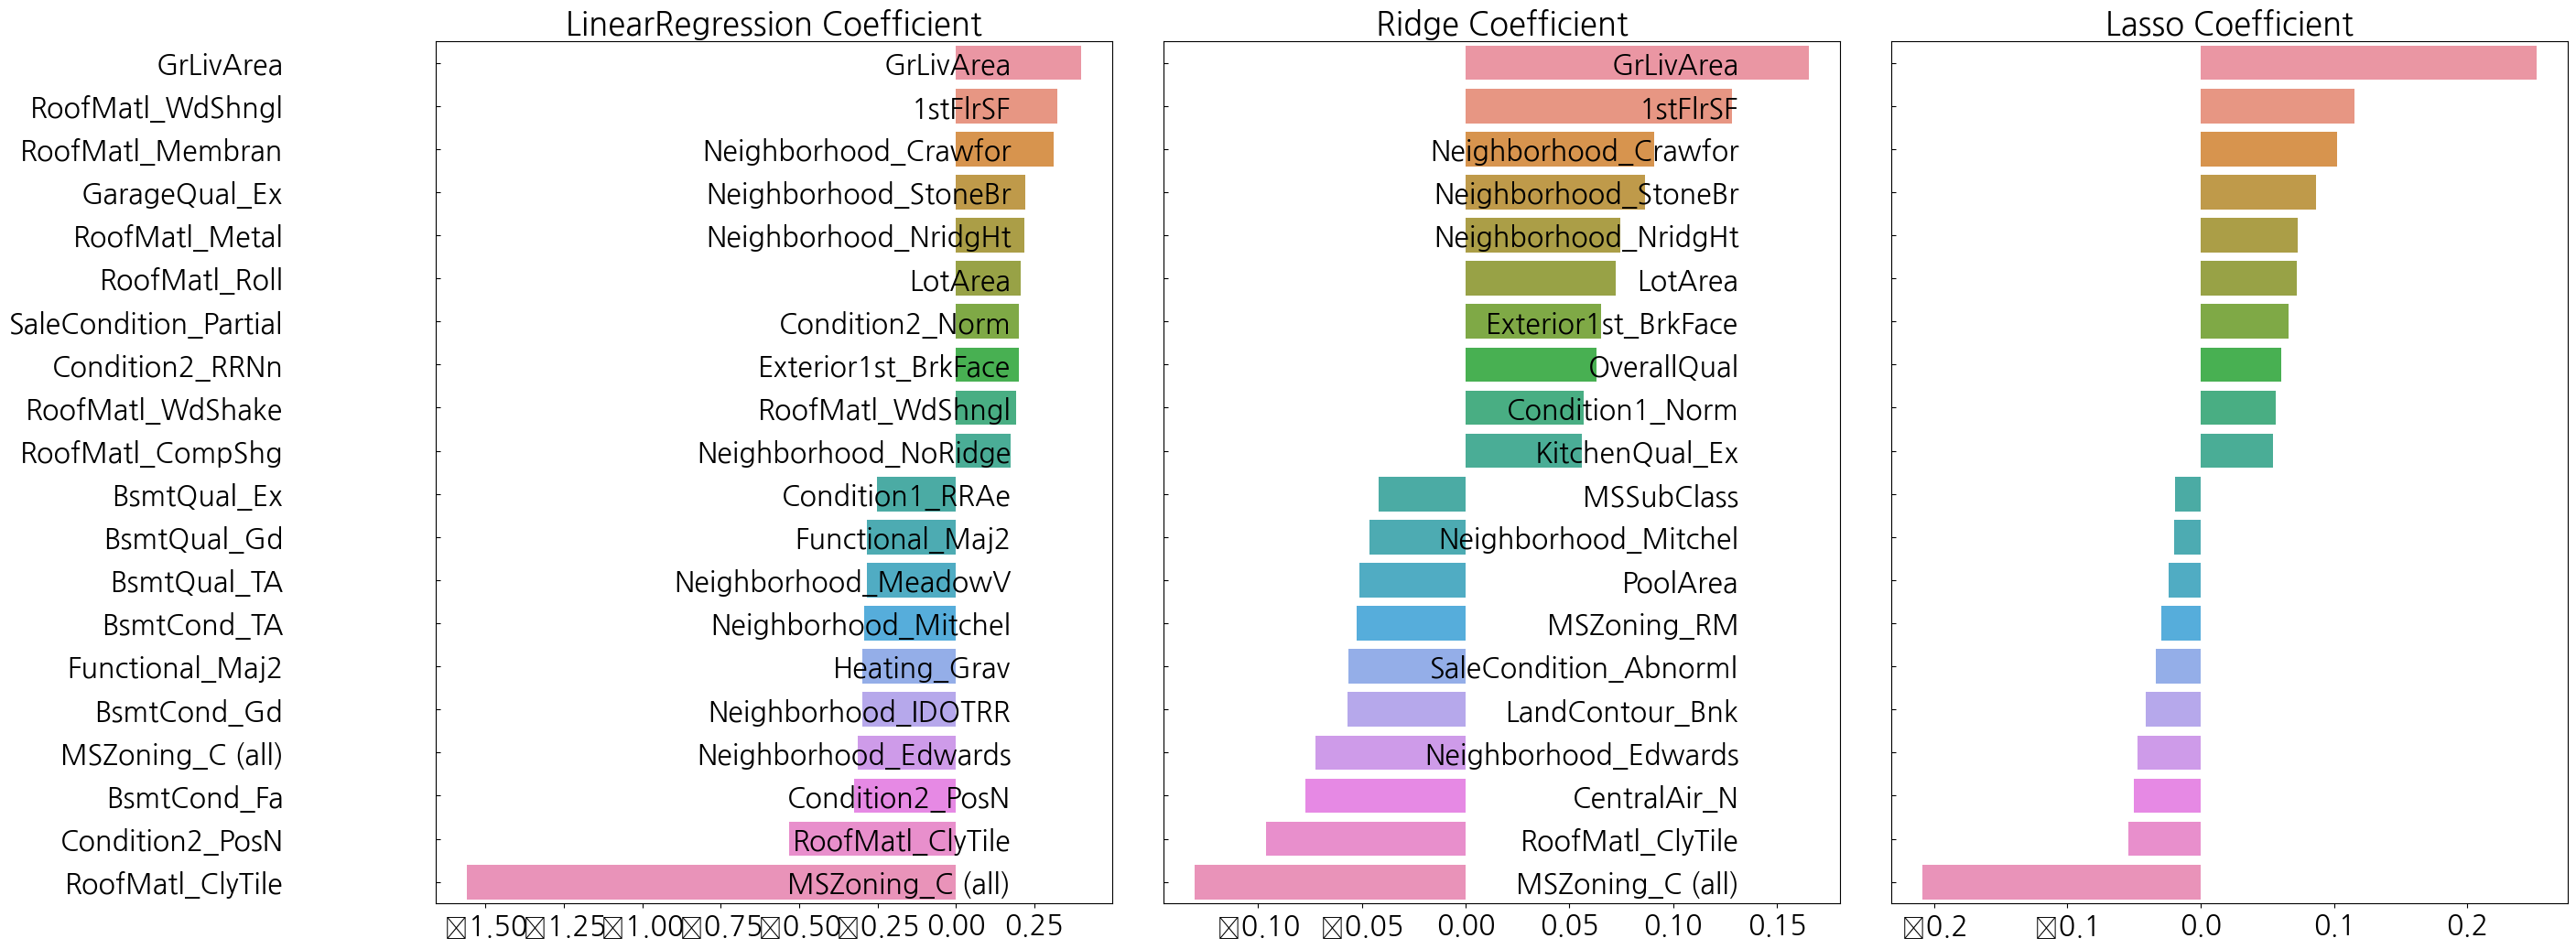

In [31]:
## 회귀 모델 재지정
## 및 학습 진행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

## 릿지 모델 재지정 (알파값 부여)
## 및 학습 진행
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)

## 라쏘 모델 재지정
## 및 학습 진행
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

## RMSE값 받아보기
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

## 시각화 확인
visualize_coefficient(models)

## 이상치 확인 및 제거  
  
* 칼럼이 많기 때문에, 모든 칼럼에 대한 이상치를 처리하기는 어렵다.  
* 때문에, 종속변수에 "큰 영향"을 주는 칼럼(feature)를 위주로 이상치 처리를 진행하는 게 효과적이다.  

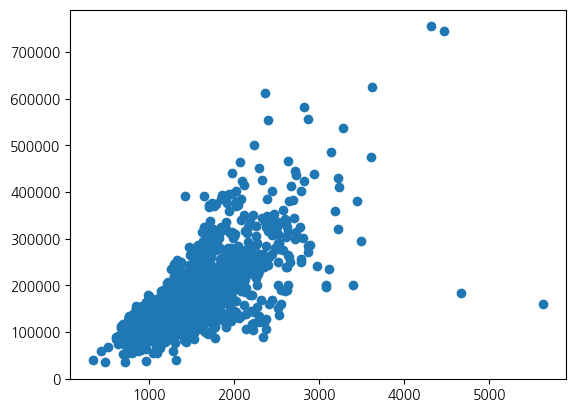

In [35]:
# 원천 데이터를 불러와, 가장 큰 영향을 미치는 독립변수의 분포를 살펴본다.
## 가격 4000 ~ 5000쪽에, LivArea가 큰데도 가격이 낮은 관측값이 있다. = 이상치

df_org = pd.read_csv('houseprice.csv')
plt.scatter(x=df_org['GrLivArea'], y=df_org['SalePrice'])
plt.xlabel = 'GrLivArea'
plt.ylabel = 'SalePrice'

## 이상치 제거 후 재평가

In [44]:
# 이상치 제거
## 현재 다루고 있는 df_ohe에서 해당 이상치를 제거하려 한다.
## 주의할 점. df_ohe는 스케일링을 통해 로그처리가 되어있다.

cond1 = df_ohe['GrLivArea'] > np.log1p(4000) # 컨디션(조긴)1번 : GrLivArea가 4000 이상인 경우
cond2 = df_ohe['SalePrice'] < np.log1p(300000) # 컨디션(조건)2번 : SalePrice가 300000 이하인 경우

print('이상치 제거 전 : \n', df_ohe.count()) # 이상치 제거 전 데이터 수 1,460개

outlier = df_ohe[cond1 & cond2].index # 두 조건을 모두 만족하는 index 값을 확인한다.

df_ohe.drop(index=outlier, inplace=True) # 두 조건을 모두 만족하는 index를 drop 한다.

print('이상치 제거 후 : \n', df_ohe.count()) # 이상치 제거 후 데이터 수 1,458개

이상치 제거 전 : 
 MSSubClass               1458
LotFrontage              1458
LotArea                  1458
OverallQual              1458
OverallCond              1458
                         ... 
SaleCondition_AdjLand    1458
SaleCondition_Alloca     1458
SaleCondition_Family     1458
SaleCondition_Normal     1458
SaleCondition_Partial    1458
Length: 271, dtype: int64
이상치 제거 후 : 
 MSSubClass               1458
LotFrontage              1458
LotArea                  1458
OverallQual              1458
OverallCond              1458
                         ... 
SaleCondition_AdjLand    1458
SaleCondition_Alloca     1458
SaleCondition_Family     1458
SaleCondition_Normal     1458
SaleCondition_Partial    1458
Length: 271, dtype: int64


In [45]:
## 데이터셋 나누기
y = df_ohe['SalePrice']
X = df_ohe.drop(columns = 'SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=156)

## Ridge 모델 파라미터 best param 알아보기
## 이번에는 best alpha 값이 8이 나온다.
print_best_param = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
print_best_params(ridge_reg, print_best_param)

## Ridge 모델 파라미터 best param 알아보기
print_best_param = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(lasso_reg, print_best_param)

Ridge 5cv시 최적 평균 rmse 값 : 0.1125  최적 alpha값 : {'alpha': 8}
Lasso 5cv시 최적 평균 rmse 값 : 0.1122  최적 alpha값 : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :  0.129
Ridge 로그 변환된 RMSE :  0.103
Lasso 로그 변환된 RMSE :  0.1


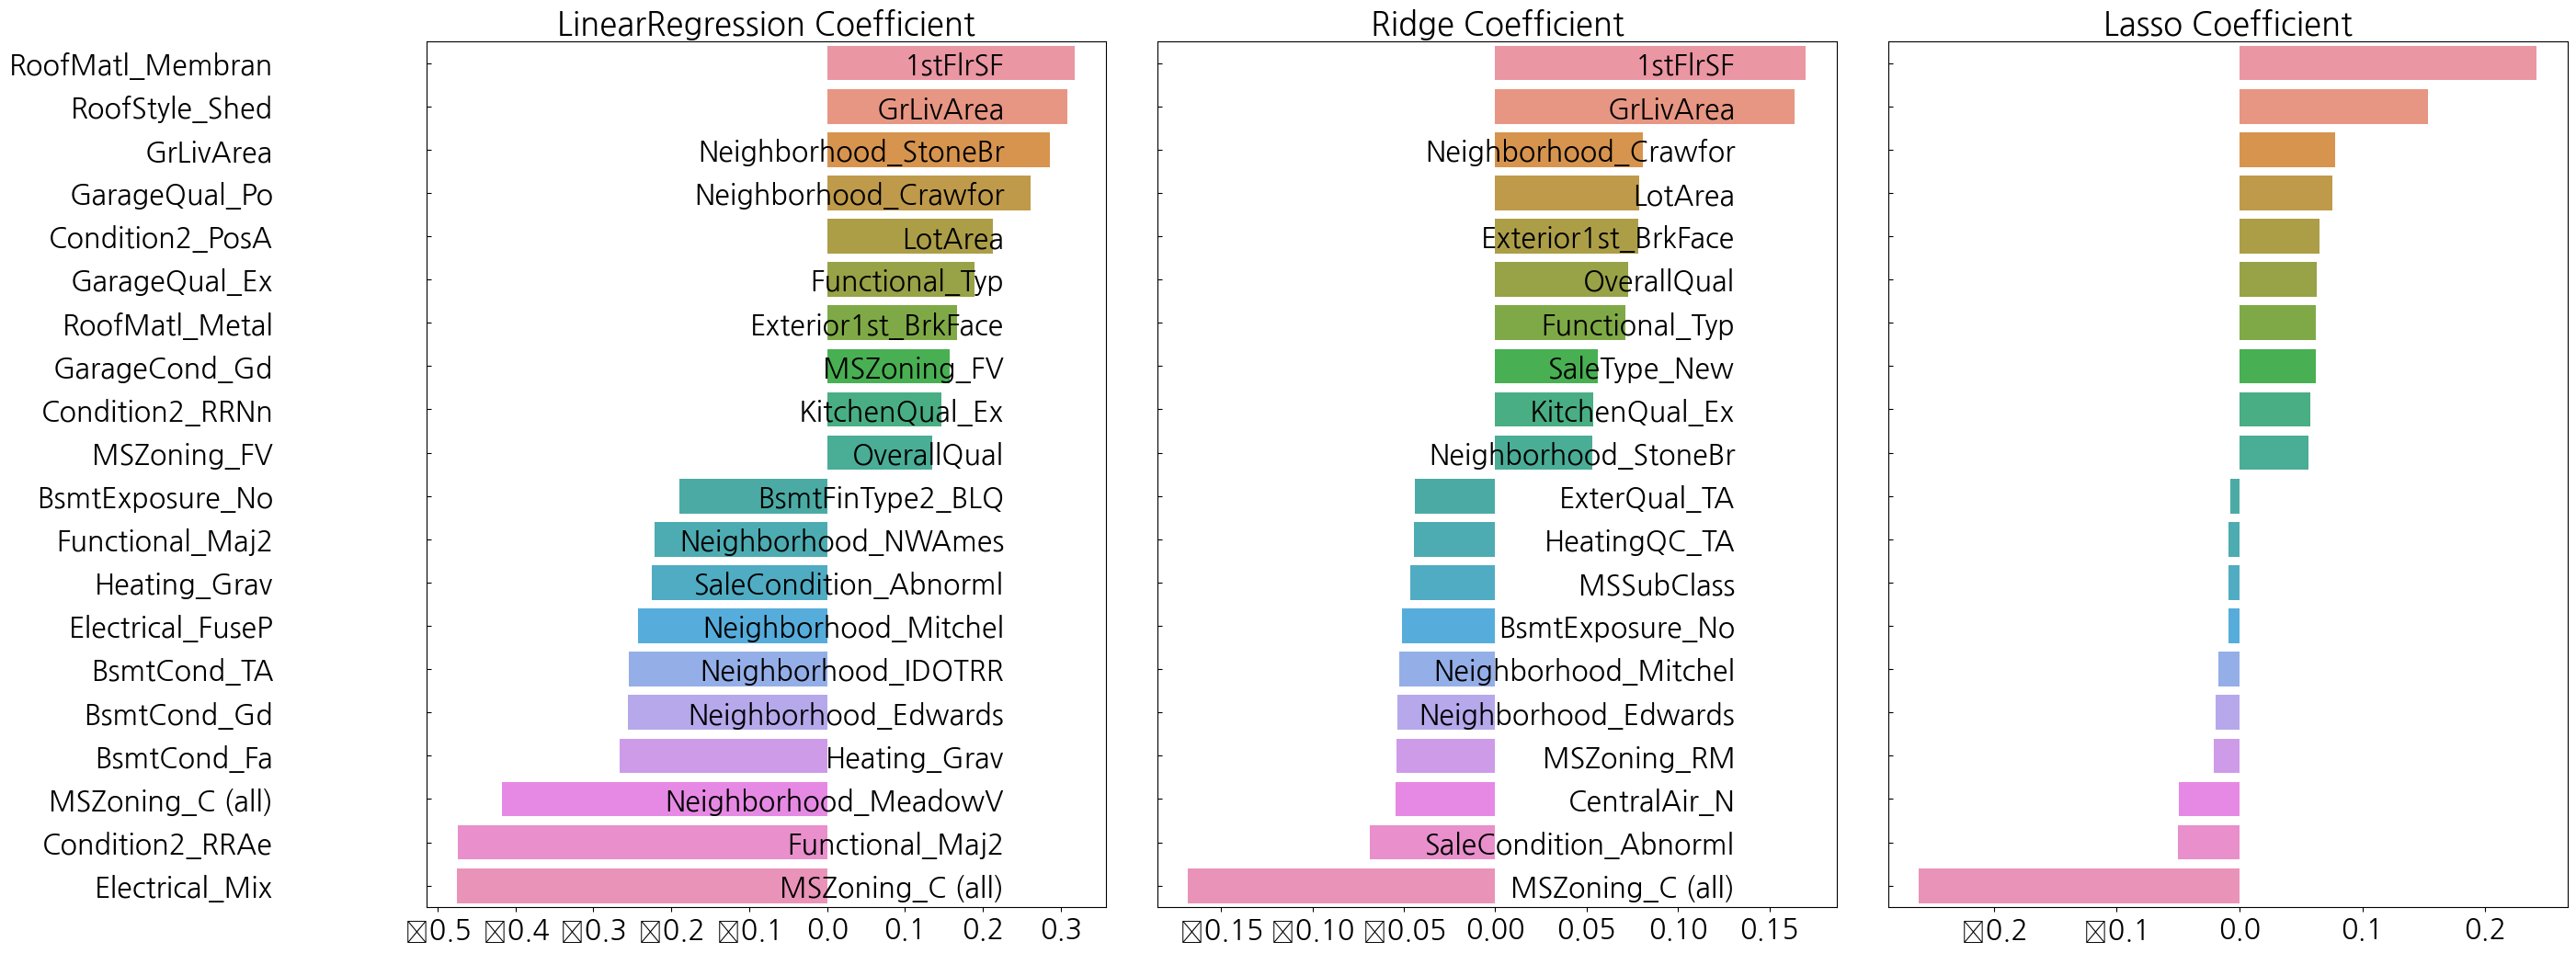

In [46]:
## 회귀 모델 재지정
## 및 학습 진행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

## 릿지 모델 재지정 (알파값 부여)
## 및 학습 진행
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

## 라쏘 모델 재지정
## 및 학습 진행
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

## RMSE값 받아보기
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

## 시각화 확인
visualize_coefficient(models)

## 이후, 다른 모델들 돌려보고 잘 나오는 것으로 하면 됨

# 회귀 모델의 예측 결과 혼합을 통한 최종 예측  

* 각기 다른 모델 A, B에 대해 두 모델이 예측한 값을 비율을 정해 최종 예측값을 산정하는 것  
* A = [100, 80, 60] / B = [120, 80, 50] 이었을 때, 4:6로 결과값을 사용한다고 하면  
* 최종 혼합모델 = [112, 80, 54] 이 나오게 된다.  
* 이렇게 혼합모델을 사용할 경우, 소폭 성능 개선이 이뤄진다.  

# 차원 축소  
  
* 차원(변수=feature) 축소를 한다는 것.  
* 목적 : 다중공선성 감소, 데이터 해석력 증가  
* 단계 : (1) 피처 선택 (2) 피처 추출 